In [1]:
import os

os.environ["http_proxy"] = "http://localhost:7890"
os.environ["https_proxy"] = "http://localhost:7890"

3.2获取金融市场数据

3.2.1下载数据到指定目录

使用Qlib内置的数据源并下载到本地目录，用于后续研究使用：

In [2]:
import qlib
# from qlib.contrib.model.pytorch_alstm_ts import ALSTM
from qlib.constant import REG_CN
import os
# 忽略警告
import warnings

warnings.filterwarnings('ignore')

data_uri = ':/data/qlib/qlib_data/cn_data'
data_uri = 'H' + data_uri if os.path.exists('H' + data_uri) else 'E' + data_uri
# GetData().qlib_data(target_dir=data_uri, region=REG_CN)
qlib.init(provider_uri=data_uri, region=REG_CN)

[25080:MainThread](2024-03-05 23:05:33,859) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[25080:MainThread](2024-03-05 23:05:34,552) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[25080:MainThread](2024-03-05 23:05:34,554) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('H:/data/qlib/qlib_data/cn_data')}


3.2.3数据核心模块类

Qlib中关于数据主要有以下三个模块：

Data Loader: 从数据源加载数据，数据源可以是已经转换为qlib内置格式的数据，也可以是其他外部数据；

Data Handler: 对数据进行预处理，比如常见的缺失值、标准化等；

Dataset: 为模型的训练准备数据，类似Pytorch中的Dataset。

1)QlibDataLoader

In [3]:
from qlib.data.dataset.loader import QlibDataLoader

# 除了直接加载原始特征，有时我们需要对不同的原始特征做一些运算生成新的特征，比如我们想计算收盘价的均线。这时我们可以使用qlib的算式表达式功能，直接在加载时进行计算
QlibDataLoader(config=(
    ['$open', '$high', '$low', '$close', '$volume', '$change', '$factor', 'EMA($close, 10)', 'EMA($close, 30)',
     '$close/$factor'],
    ['open', 'high', 'low', 'close', 'volume', 'change', 'factor', 'EMA10', 'EMA30', 'raw_close'])
).load(instruments=['SH600519'], start_time='20090105', end_time='20200925')

,,open,high,low,close,volume,change,factor,EMA10,EMA30,raw_close
datetime,instrument,,,,,,,,,,
2009-01-05,SH600519,14.088112,14.291379,13.766463,13.944010,10497168.0,-0.002944,0.171244,14.129837,14.297894,81.427505
2009-01-06,SH600519,13.830784,14.049516,13.545165,13.986463,29655306.0,0.003045,0.171245,14.100548,14.274892,81.675400
2009-01-07,SH600519,14.013484,14.023776,13.727865,13.739442,11843768.0,-0.017661,0.171244,14.028399,14.235709,80.232903
2009-01-08,SH600519,13.541313,13.968466,13.406219,13.963312,14483822.0,0.016294,0.171245,14.015625,14.215948,81.540199
2009-01-09,SH600519,13.841075,13.965878,13.766464,13.803778,9171688.0,-0.011425,0.171244,13.974638,14.186284,80.608597
...,...,...,...,...,...,...,...,...,...,...,...
2020-09-21,SH600519,360.617889,360.617889,355.057648,355.087494,10535369.0,-0.016637,0.213035,364.378723,363.418030,1666.800049
2020-09-22,SH600519,351.508484,359.386536,351.508484,354.850983,10920939.0,-0.000666,0.213035,362.646393,362.865326,1665.689819
2020-09-23,SH600519,348.312958,354.919189,345.334717,351.504211,16769754.0,-0.009432,0.213035,360.620544,362.132355,1649.979858


In [4]:
# instruments可以是个股代码（返回时序数据）或股票池代码（返回面板数据）
QlibDataLoader(config=(
    ['EMA($close, 10)', 'EMA($close, 30)'],
    ['EMA10', 'EMA30'])
).load(instruments='csi100',  # 沪深300股票池代码，在instruments文件夹下有对应的sh000300.txt
       start_time='20190101', end_time='20190110')

EMA10      EMA30
datetime   instrument                      
2019-01-02 SH600000     7.092837   7.416340
           SH600009    16.543882  16.482178
           SH600010     5.285407   5.401525
           SH600011     2.703071   2.677347
           SH600015     5.976167   6.117362
...                          ...        ...
2019-01-10 SZ002415     8.722863   8.680843
           SZ002450     5.595629   6.127040
           SZ002594     2.021440   2.096986
           SZ002736     1.119112   1.119617
           SZ300059    10.143766  10.217589

[700 rows x 2 columns]

qlib把类似“EMA”称为算子（operator），qlib中全部支持的算子可以在以下源码中找到：/qlib/data/ops.py中，主要有：

ChangeInstrument, Rolling, Ref, Max, Min, Sum, Mean, Std, Var, Skew, Kurt, Med, Mad, Slope, Rsquare, Resi, Rank, Quantile, Count, EMA, WMA, Corr, Cov, Delta, Abs, Sign, Log, Power, Add, Sub, Mul, Div, Greater, Less, And, Or, Not, Gt, Ge, Lt, Le, Eq, Ne, Mask, IdxMax, IdxMin, If, Feature, PFeature，




In [5]:
# 有时我们需要对计算的数据进行分组，最常用的是分为特征组“feature”和“label”组，此时我们可以传入dict格式的参数至config中
QlibDataLoader(config={
    'feature': (
        ['EMA($close, 10)', 'EMA($close, 30)'],
        ['EMA10', 'EMA30']),
    'label': (
        ["Ref($close, -1)/$close-1"],
        ['next_ret'])}
).load(instruments='csi100', start_time='20190101', end_time='20190110')

feature                label
                           EMA10      EMA30  next_ret
datetime   instrument                                
2019-01-02 SH600000     7.092837   7.416340  0.011340
           SH600009    16.543882  16.482178 -0.013497
           SH600010     5.285407   5.401525  0.013605
           SH600011     2.703071   2.677347 -0.026426
           SH600015     5.976167   6.117362  0.005472
...                          ...        ...       ...
2019-01-10 SZ002415     8.722863   8.680843  0.004236
           SZ002450     5.595629   6.127040 -0.033163
           SZ002594     2.021440   2.096986  0.003480
           SZ002736     1.119112   1.119617  0.001148
           SZ300059    10.143766  10.217589  0.011990

[700 rows x 3 columns]

2）Data Handler

通过Data Loader加载特征后，模型训练前需要对特征数据进行一些预处理，比如缺失值、标准化等处理。这是Data Handler主要任务。我们先看一个案例：



Return    12
dtype: int64


[25080:MainThread](2024-03-05 23:06:46,696) INFO - qlib.timer - [log.py:127] - Time cost: 13.989s | Loading data Done
[25080:MainThread](2024-03-05 23:06:46,699) INFO - qlib.timer - [log.py:127] - Time cost: 0.001s | DropnaProcessor Done
[25080:MainThread](2024-03-05 23:06:46,711) INFO - qlib.timer - [log.py:127] - Time cost: 0.011s | CSZScoreNorm Done
[25080:MainThread](2024-03-05 23:06:46,712) INFO - qlib.timer - [log.py:127] - Time cost: 0.014s | fit & process data Done
[25080:MainThread](2024-03-05 23:06:46,713) INFO - qlib.timer - [log.py:127] - Time cost: 14.006s | Init data Done


Return    0
dtype: int64


array([[<Axes: title={'center': 'Return'}>]], dtype=object)

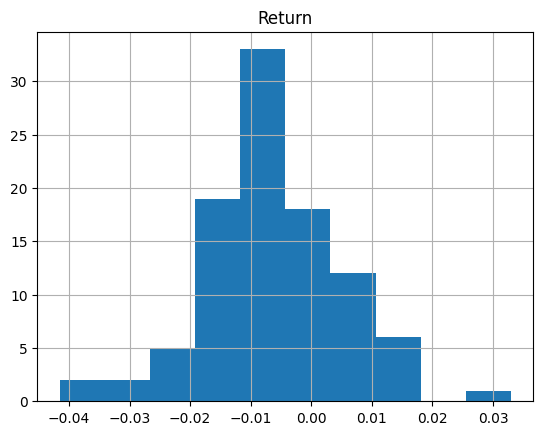

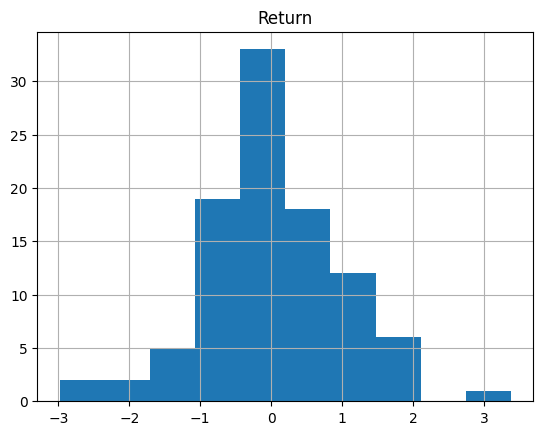

In [6]:
from qlib.data.dataset.handler import DataHandlerLP
from qlib.data.dataset.processor import CSZScoreNorm, DropnaProcessor

##################################
qdl = QlibDataLoader(config=(['$close/Ref($close, 1)-1'], ['Return']))
df = qdl.load(instruments='csi100', start_time='20190101', end_time='20190110')
# 是否有空值
print(df.isna().sum())
# 原始数据分布
df.xs('2019-01-10').hist()
##################################
dh = DataHandlerLP(  # DataHandler with (L)earnable (P)rocessor
    instruments='csi100', start_time='20190101', end_time='20190110',
    learn_processors=[DropnaProcessor(), CSZScoreNorm()],  # 先去空值，再截面标准化
    data_loader=qdl)
#     - DK_R / self._data: the raw data loaded from the loader
#     - DK_I / self._infer: the data processed for inference
#     - DK_L / self._learn: the data processed for learning model.
df_hdl = dh.fetch(data_key=DataHandlerLP.DK_L)  # (D)ata (K)ey 'learn'
# 查看是否还存在空值
print(df_hdl.isna().sum())
# CSZScoreNorm截面标准化处理后的数据分布
df_hdl.xs('2019-01-10').hist()

从以上的例子可以看出，实例化Data Handler需要以下几个参数：

基本信息，如instruments，start_time，end_time

infer_processors，数据处理器，列表格式。由Dataloader加载的数据会依次经过该列表中的processor进行处理。（后面会详细介绍）

data_loader，数据加载器实例。

Data Handler实例化之后，通过fetch方法获取处理后的数据，这里的参数DataHandlerLP.DK_L会在Learn Processor VS Infer Processor详细介绍。

3）Dataset

Dataset主要是为模型训练注入数据，其中主要的参数有：

handler：实例化的Data Handler

segment：训练、验证、测试数据集的划分

一个完整的代码示例如下：

In [7]:
from qlib.data.dataset.processor import ZScoreNorm
from qlib.data.dataset import DatasetH

market = 'csi100'
qdl_ma_gp = QlibDataLoader(config={
    'feature': (
        ['EMA($close, 10)', 'EMA($close, 30)'],
        ['EMA10', 'EMA30']),
    'label': (
        ["Ref($close, -1)/$close-1"],  # Ref($close, -1)表示下一日收盘价
        ['next_ret'])})  # 下一日收益率
dh_pr_test = DataHandlerLP(
    instruments='csi100',
    start_time='20160101',
    end_time='20191231',
    process_type=DataHandlerLP.PTYPE_I,
    # PTYPE_I = "independent"
    # # - self._infer will be processed by shared_processors + infer_processors
    # # - self._learn will be processed by shared_processors + learn_processors
    # PTYPE_A = "append"
    # # - self._infer will be processed by shared_processors + infer_processors
    # # - self._learn will be processed by shared_processors + infer_processors + learn_processors    
    infer_processors=[ZScoreNorm(fit_start_time='20160101', fit_end_time='20181231')],
    # processor that applies z-score normalization
    learn_processors=[CSZScoreNorm()],  # processor that applies cross sectional z-score normalization
    shared_processors=[DropnaProcessor()],
    data_loader=qdl_ma_gp)
ds = DatasetH(dh_pr_test, segments={"train": ('20160101', '20181231'), "test": ('20190101', '20191231')})
# 准备训练数据
ds.prepare('train')

[25080:MainThread](2024-03-05 23:07:15,109) INFO - qlib.timer - [log.py:127] - Time cost: 28.058s | Loading data Done
[25080:MainThread](2024-03-05 23:07:15,116) INFO - qlib.timer - [log.py:127] - Time cost: 0.006s | DropnaProcessor Done
[25080:MainThread](2024-03-05 23:07:15,176) INFO - qlib.timer - [log.py:127] - Time cost: 0.058s | ZScoreNorm Done
[25080:MainThread](2024-03-05 23:07:16,305) INFO - qlib.timer - [log.py:127] - Time cost: 1.125s | CSZScoreNorm Done
[25080:MainThread](2024-03-05 23:07:16,306) INFO - qlib.timer - [log.py:127] - Time cost: 1.196s | fit & process data Done
[25080:MainThread](2024-03-05 23:07:16,306) INFO - qlib.timer - [log.py:127] - Time cost: 29.255s | Init data Done


EMA10     EMA30  next_ret
datetime   instrument                              
2016-01-04 SH600000   -0.120305 -0.120022  0.469636
           SH600010   -0.119592 -0.118803  1.274610
           SH600011   -0.140072 -0.140143 -0.120704
           SH600015   -0.124963 -0.125563  0.276519
           SH600016   -0.099245 -0.100489  0.520611
...                         ...       ...       ...
2018-12-28 SZ002415   -0.121156 -0.120752 -0.216053
           SZ002450   -0.129216 -0.127331 -2.704178
           SZ002594   -0.142672 -0.142801 -1.851776
           SZ002736   -0.146067 -0.146235 -0.427841
           SZ300059   -0.116066 -0.115437 -1.064005

[68157 rows x 3 columns]

In [8]:
# 准备测试数据
ds.prepare('test')

EMA10     EMA30  next_ret
datetime   instrument                              
2019-01-02 SH600000   -0.125632 -0.124848  0.591682
           SH600009   -0.094255 -0.094215 -0.693500
           SH600010   -0.131899 -0.131677  0.708892
           SH600011   -0.140658 -0.141039 -1.362451
           SH600015   -0.129555 -0.129227  0.288035
...                         ...       ...       ...
2019-12-31 SZ002594   -0.143487 -0.143866  0.547622
           SZ002736   -0.144432 -0.144773  1.530397
           SZ300015   -0.083752 -0.082330 -0.073581
           SZ300059   -0.099507 -0.100803  0.431442
           SZ300498   -0.146499 -0.146646  1.098290

[23969 rows x 3 columns]

4.1数据
1）初始化

2）获取交易日期和全部股票代码

In [9]:
# 获取日历
from qlib.data import D

tradedate = D.calendar(start_time='2020-01-01', end_time='2020-11-30', freq='day')
print(tradedate[:5])
# 获取所有证券代码
instruments = D.instruments(market='all')
stock_list = D.list_instruments(instruments=instruments,
                                start_time='2020-07-01',
                                end_time='2020-11-30',
                                as_list=True)
print(stock_list[-5:])

[Timestamp('2020-01-02 00:00:00') Timestamp('2020-01-03 00:00:00')
 Timestamp('2020-01-06 00:00:00') Timestamp('2020-01-07 00:00:00')
 Timestamp('2020-01-08 00:00:00')]
['SZ300891', 'SZ300892', 'SZ300893', 'SZ300895', 'SH000905']


3）获取字段数据

调用qlib.data.features模块可以获取指定股票指定日期指定字段数据，例如下图展示获取惠云钛业（SZ300891）在2020-01-01~2020-11-30日频后复权收盘价和成交量。

In [10]:
#3. 获取指定股票指定日期指定字段数据
features_df = D.features(instruments=['SZ300891'],
                         fields=['$close', ' $volume'],
                         start_time='2020-01-01',
                         end_time='2020-11-30',
                         freq='day')
print(features_df.head())

                         $close       $volume
instrument datetime                          
SZ300891   2020-09-17  1.000000  1.617669e+09
           2020-09-18  0.881890  1.203641e+09
           2020-09-21  0.871391  7.776675e+08
           2020-09-22  0.843832  6.129917e+08
           2020-09-23  0.851269  6.875450e+08


4.2股票池

使用qlib.data.filter.NameDFilter命令进行股票名称静态筛选，参数name_rule_re为纳入股票代码的正则表达式，如HK[0-9!]表示以HK开头，后续为数字或感叹号的股票代码，感叹号代表目前已退市股票。

其次，使用qlib.data.filter.ExpressionDFilter命令进行股票因子表达式的动态筛选，参数rule_expression为入选的因子表达式，如$close>=1代表收盘价应大于等于1元。

随后，通过qlib.data.instruments命令的参数filter_pipe，将两个筛选条件组装到一起，代码如下：

- 不加if __name__=='__main__' ，会报错“RuntimeError: An attempt has been made to start a new process before the current process has finished its bootstrapping phase.”


In [11]:
if __name__ == '__main__':
    from qlib.data.filter import NameDFilter, ExpressionDFilter

    # 静态Filter:深交所A股
    nameDFilter = NameDFilter(name_rule_re='SZ[0-9!]')
    # 动态Filter:后复权价格大于等于1元
    expressionDFilter = ExpressionDFilter(rule_expression='$close>=5')
    #按以上两个过滤条件获取新的股票代码集
    instruments = D.instruments(market='all', filter_pipe=[nameDFilter, expressionDFilter])
    stock_list = D.list_instruments(instruments=instruments,
                                    start_time='2020-07-01',
                                    end_time='2020-11-30',
                                    as_list=True)
    #展示条件过滤后的5个股票代码
    print(stock_list[-5:])
    # 不过滤
    instruments = D.instruments(market='all')
    stock_list = D.list_instruments(instruments=instruments,
                                    start_time='2020-07-01',
                                    end_time='2020-11-30',
                                    as_list=True)
    #展示条件过滤后的5个股票代码
    print(stock_list[-5:])

['SZ300782', 'SZ300803', 'SZ300831', 'SZ300841', 'SZ300846']
['SZ300891', 'SZ300892', 'SZ300893', 'SZ300895', 'SH000905']


4.3因子

Qlib提供Alpha158和Alpha360两类量价因子库，用户也可根据需要自定义因子库。源码位于qlib/contrib/data/handler.py，主要包括两个四个类：

Alpha360(DataHandlerLP)、Alpha360vwap(Alpha360)
Alpha158(DataHandlerLP)、Alpha158vwap(Alpha360)
配置文件对应的代码说明如下：

```python
def parse_config_to_fields(config):
 """create factors from config
        config = {
            'kbar': {}, # whether to use some hard-code kbar features
            'price': { # whether to use raw price features
                'windows': [0, 1, 2, 3, 4], # use price at n days ago
                'feature': ['OPEN', 'HIGH', 'LOW'] # which price field to use
            },
            'volume': { # whether to use raw volume features
                'windows': [0, 1, 2, 3, 4], # use volume at n days ago
            },
            'rolling': { # whether to use rolling operator based features
                'windows': [5, 10, 20, 30, 60], # rolling windows size
                'include': ['ROC', 'MA', 'STD'], # rolling operator to use
                #if include is None we will use default operators
                'exclude': ['RANK'], # rolling operator not to use
            }
        }
```
其中参数data_handler_config相当于配置文件，字典类型，用来定义完整数据起止日期（start_time和end_time），拟合数据起止日期（fit_start_time和fit_end_time），股票池（instruments）等。

拟合数据起止日期区间应为完整数据起止日期数据的子集。

拟合数据日期（训练和验证集）和余下日期（测试集）在数据预处理的方式上有所不同，将在下章展开讨论。

生成Alpha158因子调用qlib.contrib.data.handler模块下的Alpha158类，具体命令为：

```python
from qlib.contrib.data.handler import Alpha158
h = Alpha158(**data_handler_config)
```

执行上述指令后，程序将计算从start_time至end_time的**当期因子值和下期收益**，分别作为后续**AI模型训练的特征和标签**。

代码中使用了两个处理器，infer_processors用于模型预测，learn_processors用于模型训练。

```python
    infer_processors = check_transform_proc(infer_processors, fit_start_time, fit_end_time)
    learn_processors = check_transform_proc(learn_processors, fit_start_time, fit_end_time)
```

In [16]:
from qlib.contrib.data.handler import Alpha158

instruments = D.instruments(market='all')
# 设置日期、股票池等参数
data_handler_config = {
    "start_time": "2020-01-01",
    "end_time": "2020-11-30",
    "fit_start_time": "2020-01-01",
    "fit_end_time": "2020-06-30",
    "instruments": instruments
}
h = Alpha158(**data_handler_config)
# 获取列名(因子名称)
print(h.get_cols())

[19576:MainThread](2024-01-27 13:00:12,306) INFO - qlib.timer - [log.py:127] - Time cost: 125.072s | Loading data Done
[19576:MainThread](2024-01-27 13:00:12,893) INFO - qlib.timer - [log.py:127] - Time cost: 0.201s | DropnaLabel Done
G:\ProgramData\miniconda3\envs\qlibenv\lib\site-packages\qlib\data\dataset\processor.py:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cols] = df[cols].groupby("datetime", group_keys=False).apply(self.zscore_func)
[19576:MainThread](2024-01-27 13:00:13,451) INFO - qlib.timer - [log.py:127] - Time cost: 0.557s | CSZScoreNorm Done
[19576:MainThread](2024-01-27 13:00:13,478) INFO - qlib.timer - [log.py:127] - Time cost: 1.171s | fit & process data Done
[19576:MainThread](2024-01-27 13:00:13,479) INFO - qlib.time

['KMID', 'KLEN', 'KMID2', 'KUP', 'KUP2', 'KLOW', 'KLOW2', 'KSFT', 'KSFT2', 'OPEN0', 'HIGH0', 'LOW0', 'VWAP0', 'ROC5', 'ROC10', 'ROC20', 'ROC30', 'ROC60', 'MA5', 'MA10', 'MA20', 'MA30', 'MA60', 'STD5', 'STD10', 'STD20', 'STD30', 'STD60', 'BETA5', 'BETA10', 'BETA20', 'BETA30', 'BETA60', 'RSQR5', 'RSQR10', 'RSQR20', 'RSQR30', 'RSQR60', 'RESI5', 'RESI10', 'RESI20', 'RESI30', 'RESI60', 'MAX5', 'MAX10', 'MAX20', 'MAX30', 'MAX60', 'MIN5', 'MIN10', 'MIN20', 'MIN30', 'MIN60', 'QTLU5', 'QTLU10', 'QTLU20', 'QTLU30', 'QTLU60', 'QTLD5', 'QTLD10', 'QTLD20', 'QTLD30', 'QTLD60', 'RANK5', 'RANK10', 'RANK20', 'RANK30', 'RANK60', 'RSV5', 'RSV10', 'RSV20', 'RSV30', 'RSV60', 'IMAX5', 'IMAX10', 'IMAX20', 'IMAX30', 'IMAX60', 'IMIN5', 'IMIN10', 'IMIN20', 'IMIN30', 'IMIN60', 'IMXD5', 'IMXD10', 'IMXD20', 'IMXD30', 'IMXD60', 'CORR5', 'CORR10', 'CORR20', 'CORR30', 'CORR60', 'CORD5', 'CORD10', 'CORD20', 'CORD30', 'CORD60', 'CNTP5', 'CNTP10', 'CNTP20', 'CNTP30', 'CNTP60', 'CNTN5', 'CNTN10', 'CNTN20', 'CNTN30', 'CNT

其中因子对应的算子计算公式在handler.py中可以看到：

"G:\ProgramData\miniconda3\envs\qlibenv\Lib\site-packages\qlib\contrib\data\handler.py"

In [17]:
# 通过下面代码获取标签：
#获取T日每只股票的标签数据（收益，及涨幅）
Alpha158_df_label = h.fetch(col_set="label")
print(Alpha158_df_label)
# 默认参数下，股票t日的标签对应t+2日收盘价相对于t+1日收盘价的涨跌幅，相当于t日收盘后发信号，t+1日收盘时刻开仓，t+2日收盘时刻平仓。
# 如下，2020年1月2日沪深300的标签值为-0.003778，对应2020年1月6日该股票涨跌幅为-0.3778%（2020年1月4~5日非交易日）。

                         LABEL0
datetime   instrument          
2020-01-02 SH000300   -0.003778
           SH000903   -0.006925
           SH000905    0.010076
           SH600000   -0.011111
           SH600004   -0.017261
...                         ...
2020-09-25 SZ300890         NaN
           SZ300891         NaN
           SZ300892         NaN
           SZ300893         NaN
           SZ300895         NaN

[676964 rows x 1 columns]


In [18]:
# 通过下面代码可获取T日的特征（因子）值。
# 获取T日每只股票的特征(因子值)值
Alpha158_df_feature = h.fetch(col_set="feature")
print(Alpha158_df_feature)
# 默认参数下，股票t日的特征对应t日收盘后计算出的因子值。

                           KMID      KLEN     KMID2       KUP      KUP2  \
datetime   instrument                                                     
2020-01-02 SH000300    0.007495  0.012450  0.602024  0.004955  0.397976   
           SH000903    0.006225  0.011553  0.538800  0.005328  0.461200   
           SH000905    0.011207  0.016346  0.685605  0.001653  0.101117   
           SH600000    0.000000  0.015237  0.000000  0.013633  0.894736   
           SH600004   -0.002278  0.012529 -0.181813  0.003417  0.272729   
...                         ...       ...       ...       ...       ...   
2020-09-25 SZ300890   -0.058000  0.085636 -0.677282  0.027273  0.318471   
           SZ300891   -0.044214  0.074236 -0.595587  0.028930  0.389707   
           SZ300892   -0.110807  0.148837 -0.744485  0.038030  0.255515   
           SZ300893    0.032195  0.245854  0.130953  0.153659  0.625000   
           SZ300895   -0.104925  0.152836 -0.686523  0.040896  0.267578   

                        

4.4模型
直接以qlib/examples/workflow_by_code.py这个例子来看。

1、数据准备

In [2]:
import qlib
from qlib.constant import REG_CN
from qlib.utils import init_instance_by_config
from qlib.workflow import R
from qlib.utils import flatten_dict
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord
from qlib.tests.config import CSI300_BENCH

#1.初始化并获取日历
data_uri = 'E:/data/qlib/qlib_data/cn_data'
qlib.init(provider_uri=data_uri, region=REG_CN)
market = "csi300"
benchmark = "SH000300"

[19560:MainThread](2024-01-28 10:30:34,259) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[19560:MainThread](2024-01-28 10:30:34,264) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[19560:MainThread](2024-01-28 10:30:34,265) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('H:/data/qlib/qlib_data/cn_data')}


模型训练

模型训练过程主要包括：数据集和模型参数初始化->初始模型和数据集实例->model.fit(dataset)->

参数说明

Model（模型）-参数及说明：
```
 "model": {
 "class": "LGBModel", #模型名称，本代码使用的是LGBmodel
 "module_path": "qlib.contrib.model.gbdt",#AI模型所在路径
 "kwargs": {#LGBmodel的超参
 "loss": "mse",#损失函数，此处设置为均方误差
 "colsample_bytree": 0.8879,#列采样比列
 "learning_rate": 0.0421,#学习率
 "subsample": 0.8789,#行采样比例
 "lambda_l1": 205.6999,#L1正则化惩罚系数
 "lambda_l2": 580.9768,#L2正则化惩罚系数
 "max_depth": 8,#最大树深
 "num_leaves": 210,#最大叶子节点数
 "num_threads": 20,#最大并行线程数
        },
Dataset（数据集）-参数及说明
dataset": {
 "class": "DatasetH", #数据集名称
 "module_path": "qlib.data.dataset", #数据集所在路径
 "kwargs": {#DatasetH模型参数
 "handler": {#因子库参数
 "class": "Alpha158",#因子库名称，此处使用qlib自带的Alpha158
 "module_path": "qlib.contrib.data.handler",#因子库路径
 "kwargs": data_handler_config, #Alpha158的参数
            },
 "segments": {#时间区间划分参数
 "train": ("2008-01-01", "2014-12-31"),#训练集
 "valid": ("2015-01-01", "2016-12-31"),#验证集
 "test": ("2017-01-01", "2020-08-01"),#测试集
            },
        },
    },
```

其中data_handler_config参数：
```
data_handler_config = {
 "start_time": "2008-01-01",
 "end_time": "2020-08-01",
 "fit_start_time": "2008-01-01",
 "fit_end_time": "2014-12-31",
 "instruments": market,
}
```
1）代码

In [3]:
###################################
# train model
###################################
data_handler_config = {
    "start_time": "2008-01-01",
    "end_time": "2020-08-01",
    "fit_start_time": "2008-01-01",
    "fit_end_time": "2014-12-31",
    "instruments": market,
}
task = {
    "model": {
        "class": "LGBModel",
        "module_path": "qlib.contrib.model.gbdt",
        "kwargs": {
            "loss": "mse",
            "colsample_bytree": 0.8879,
            "learning_rate": 0.0421,
            "subsample": 0.8789,
            "lambda_l1": 205.6999,
            "lambda_l2": 580.9768,
            "max_depth": 8,
            "num_leaves": 210,
            "num_threads": 20,
        },
    },
    "dataset": {
        "class": "DatasetH",
        "module_path": "qlib.data.dataset",
        "kwargs": {
            "handler": {
                "class": "Alpha158",
                "module_path": "qlib.contrib.data.handler",
                "kwargs": data_handler_config,
            },
            "segments": {
                "train": ("2008-01-01", "2014-12-31"),
                "valid": ("2015-01-01", "2016-12-31"),
                "test": ("2017-01-01", "2020-08-01"),
            },
        },
    },
}
# model initiaiton
model = init_instance_by_config(task["model"])  #
dataset = init_instance_by_config(task["dataset"])
# start exp to train model
with R.start(experiment_name="train_model"):
    R.log_params(**flatten_dict(task))  # 记录参数
    model.fit(dataset)  #拟合模型
    R.save_objects(trained_model=model)  #保存模型
    rid = R.get_recorder().id  #获取记录器id

ModuleNotFoundError. CatBoostModel are skipped. (optional: maybe installing CatBoostModel can fix it.)
ModuleNotFoundError. XGBModel is skipped(optional: maybe installing xgboost can fix it).
ModuleNotFoundError.  PyTorch models are skipped (optional: maybe installing pytorch can fix it).


[19560:MainThread](2024-01-28 10:31:34,770) INFO - qlib.timer - [log.py:127] - Time cost: 60.136s | Loading data Done
[19560:MainThread](2024-01-28 10:31:35,623) INFO - qlib.timer - [log.py:127] - Time cost: 0.298s | DropnaLabel Done
G:\ProgramData\miniconda3\envs\qlibenv\lib\site-packages\qlib\data\dataset\processor.py:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cols] = df[cols].groupby("datetime", group_keys=False).apply(self.zscore_func)
[19560:MainThread](2024-01-28 10:31:39,567) INFO - qlib.timer - [log.py:127] - Time cost: 3.942s | CSZScoreNorm Done
[19560:MainThread](2024-01-28 10:31:39,634) INFO - qlib.timer - [log.py:127] - Time cost: 4.861s | fit & process data Done
[19560:MainThread](2024-01-28 10:31:39,635) INFO - qlib.timer

Training until validation scores don't improve for 50 rounds
[20]	train's l2: 0.990585	valid's l2: 0.994309
[40]	train's l2: 0.986931	valid's l2: 0.993693
[60]	train's l2: 0.984352	valid's l2: 0.99349
[80]	train's l2: 0.982319	valid's l2: 0.993382
[100]	train's l2: 0.980442	valid's l2: 0.99331
[120]	train's l2: 0.97871	valid's l2: 0.993247
[140]	train's l2: 0.976987	valid's l2: 0.993334
[160]	train's l2: 0.97536	valid's l2: 0.993338
Early stopping, best iteration is:
[122]	train's l2: 0.978519	valid's l2: 0.993238


[19560:MainThread](2024-01-28 10:32:03,116) INFO - qlib.timer - [log.py:127] - Time cost: 0.725s | waiting `async_log` Done


模型按设置的参数进行训练直到验证分数50轮内没有提高，在所有训练结果中，最好的训练参数值是：0.978519，最好的验证参数值是：0.993238

4.6策略
策略思路：TopkDropout策略：

每日等权持有topk=50只股票，同时每日卖出持仓股票中最新预测收益最低的n_drop=5只股票，买入未持仓股票中最新预测收益最高的n_drop=5只股票。

策略参数如下：
```
 "strategy": {
 "class": "TopkDropoutStrategy", #策略名称
 "module_path": "qlib.contrib.strategy.signal_strategy", #策略所在路径
 "kwargs": { #TopkDropout 策略参数
 "model": model,#模型
 "dataset": dataset,#数据集
 "topk": 50,#每日持仓股票
 "n_drop": 5,#每日换仓股票
        },
```
4.6回测
回测参数设置如下：
```
 "backtest": {#回测参数
 "start_time": "2017-01-01",#回测开始时间
 "end_time": "2020-08-01",#回测结束时间
 "account": 100000000,#起始资金
 "benchmark": benchmark,#业绩比较基准
 "exchange_kwargs": {#交易参数
 "freq": "day",#日频
 "limit_threshold": 0.095,#涨跌停限制
 "deal_price": "close",#成交价格，按收盘价
 "open_cost": 0.0005,#开仓交易费率，万5佣金
 "close_cost": 0.0015,#平仓交易费率，千1印花税+万5佣金
 "min_cost": 5,#最低交易费用5元
        },
    },
```
调用qlib.workflow模块正式进行回测，依次执行如下命令：

获取上步模型训练值记录，并通过load_object读取：
```python
recorder = R.get_recorder(recorder_id=rid, experiment_name="train_model")
model = recorder.load_object("trained_model")
```
使用SignalRecord，针对测试集数据，使用训练完的模型生成预测值；
```python
# 使用SignalRecord，针对测试集数据，使用训练完的模型生成预测值；
# prediction
recorder = R.get_recorder()
ba_rid = recorder.id
sr = SignalRecord(model, dataset, recorder)
sr.generate()
```

In [7]:
with R.start(experiment_name="train_model"):
    R.log_params(**flatten_dict(task))  # 记录参数
    model.fit(dataset)  #拟合模型
    R.save_objects(trained_model=model)  #保存模型
    rid = R.get_recorder().id  #获取记录器id
    recorder = R.get_recorder(recorder_id=rid, experiment_name="train_model")
    model = recorder.load_object("trained_model")
    # 使用SignalRecord，针对测试集数据，使用训练完的模型生成预测值；
    # prediction
    recorder = R.get_recorder()
    ba_rid = recorder.id
    sr = SignalRecord(model, dataset, recorder)
    sr.generate()

[19560:MainThread](2024-01-28 10:34:08,794) INFO - qlib.workflow - [exp.py:258] - Experiment 1 starts running ...
[19560:MainThread](2024-01-28 10:34:08,856) INFO - qlib.workflow - [recorder.py:341] - Recorder dad9671b8cf542a3806729bf4fd07a3d starts running under Experiment 1 ...


Training until validation scores don't improve for 50 rounds
[20]	train's l2: 0.990585	valid's l2: 0.994309
[40]	train's l2: 0.986931	valid's l2: 0.993693
[60]	train's l2: 0.984352	valid's l2: 0.99349
[80]	train's l2: 0.982319	valid's l2: 0.993382
[100]	train's l2: 0.980442	valid's l2: 0.99331
[120]	train's l2: 0.97871	valid's l2: 0.993247
[140]	train's l2: 0.976987	valid's l2: 0.993334
[160]	train's l2: 0.97536	valid's l2: 0.993338
Early stopping, best iteration is:
[122]	train's l2: 0.978519	valid's l2: 0.993238


[19560:MainThread](2024-01-28 10:34:31,125) INFO - qlib.workflow - [record_temp.py:195] - Signal record 'pred.pkl' has been saved as the artifact of the Experiment 1
[19560:MainThread](2024-01-28 10:34:31,276) INFO - qlib.timer - [log.py:127] - Time cost: 0.101s | waiting `async_log` Done


'The following are prediction results of the LGBModel model.'
                          score
datetime   instrument          
2017-01-03 SH600000   -0.042865
           SH600008    0.005925
           SH600009    0.030596
           SH600010   -0.013973
           SH600015   -0.141758


In [9]:
# backtest & analysis
port_analysis_config = {
    "executor": {
        "class": "SimulatorExecutor",
        "module_path": "qlib.backtest.executor",
        "kwargs": {
            "time_per_step": "day",
            "generate_portfolio_metrics": True,
        },
    },
    "strategy": {
        "class": "TopkDropoutStrategy",
        "module_path": "qlib.contrib.strategy.signal_strategy",
        "kwargs": {
            "signal": (model, dataset),
            "topk": 50,
            "n_drop": 5,
        },
    },
    "backtest": {
        "start_time": "2017-01-01",
        "end_time": "2020-08-01",
        "account": 100000000,
        "benchmark": CSI300_BENCH,
        "exchange_kwargs": {
            "freq": "day",
            "limit_threshold": 0.095,
            "deal_price": "close",
            "open_cost": 0.0005,
            "close_cost": 0.0015,
            "min_cost": 5,
        },
    },
}
par = PortAnaRecord(recorder, port_analysis_config, "day")
par.generate()

[19560:MainThread](2024-01-28 10:35:33,758) INFO - qlib.backtest caller - [__init__.py:93] - Create new exchange
[19560:MainThread](2024-01-28 10:36:06,981) WARNING - qlib.online operator - [exchange.py:219] - $close field data contains nan.
[19560:MainThread](2024-01-28 10:36:06,985) WARNING - qlib.online operator - [exchange.py:219] - $close field data contains nan.
[19560:MainThread](2024-01-28 10:36:07,002) WARNING - qlib.online operator - [exchange.py:226] - factor.day.bin file not exists or factor contains `nan`. Order using adjusted_price.
[19560:MainThread](2024-01-28 10:36:07,003) WARNING - qlib.online operator - [exchange.py:228] - trade unit 100 is not supported in adjusted_price mode.
[19560:MainThread](2024-01-28 10:36:11,827) WARNING - qlib.data - [data.py:666] - load calendar error: freq=day, future=True; return current calendar!
[19560:MainThread](2024-01-28 10:36:11,829) WARNING - qlib.data - [data.py:669] - You can get future calendar by referring to the following doc

backtest loop:   0%|          | 0/871 [00:00<?, ?it/s]

G:\ProgramData\miniconda3\envs\qlibenv\lib\site-packages\qlib\utils\index_data.py:481: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
G:\ProgramData\miniconda3\envs\qlibenv\lib\site-packages\qlib\utils\index_data.py:481: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
G:\ProgramData\miniconda3\envs\qlibenv\lib\site-packages\qlib\utils\index_data.py:481: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
[19560:MainThread](2024-01-28 10:36:26,837) INFO - qlib.workflow - [record_temp.py:504] - Portfolio analysis record 'port_analysis_1day.pkl' has been saved as the artifact of the Experiment 1
[19560:MainThread](2024-01-28 10:36:26,854) INFO - qlib.workflow - [record_temp.py:529] - Indicator analysis record 'indicator_analysis_1day.pkl' has been saved as the artifact of the Experiment 1


'The following are analysis results of benchmark return(1day).'
                       risk
mean               0.000477
std                0.012295
annualized_return  0.113561
information_ratio  0.598699
max_drawdown      -0.370479
'The following are analysis results of the excess return without cost(1day).'
                       risk
mean               0.000748
std                0.005687
annualized_return  0.178088
information_ratio  2.029781
max_drawdown      -0.057265
'The following are analysis results of the excess return with cost(1day).'
                       risk
mean               0.000553
std                0.005685
annualized_return  0.131583
information_ratio  1.500251
max_drawdown      -0.066180
'The following are analysis results of indicators(1day).'
     value
ffr    1.0
pa     0.0
pos    0.0


4.7分析
前面的回测结果都以pkl文件格式存储的，所以先加载相关回测结果文件
```python
from qlib.contrib.report import analysis_model, analysis_position
from qlib.data import D
recorder = R.get_recorder(recorder_id=ba_rid, experiment_name="backtest_analysis")
print(recorder)
pred_df = recorder.load_object("pred.pkl")
report_normal_df = recorder.load_object("portfolio_analysis/report_normal_1day.pkl")
positions = recorder.load_object("portfolio_analysis/positions_normal_1day.pkl")
analysis_df = recorder.load_object("portfolio_analysis/port_analysis_1day.pkl")
```
AnalysisPosition持仓分析，分report和 risk analysis两部分。
```python
analysis_position.report_graph(report_normal_df)
analysis_position.risk_analysis_graph(analysis_df, report_normal_df)
Analysismode
label_df = dataset.prepare("test", col_set="label")
label_df.columns = ["label"]
```
IC值：

```python
pred_label = pd.concat([label_df, pred_df], axis=1, sort=True).reindex(label_df.index)
analysis_position.score_ic_graph(pred_label)
Model performance
analysis_model.model_performance_graph(pred_label)
```

In [11]:
import pandas as pd

with R.start(experiment_name="train_model"):
    R.log_params(**flatten_dict(task))  # 记录参数
    model.fit(dataset)  #拟合模型
    R.save_objects(trained_model=model)  #保存模型
    rid = R.get_recorder().id  #获取记录器id
    recorder = R.get_recorder(recorder_id=rid, experiment_name="train_model")
    model = recorder.load_object("trained_model")
    # 使用SignalRecord，针对测试集数据，使用训练完的模型生成预测值；
    # prediction
    recorder = R.get_recorder()
    ba_rid = recorder.id
    sr = SignalRecord(model, dataset, recorder)
    sr.generate()
    from qlib.contrib.report import analysis_model, analysis_position

    recorder = R.get_recorder(recorder_id=ba_rid, experiment_name="backtest_analysis")
    print(recorder)
    pred_df = recorder.load_object("pred.pkl")
    report_normal_df = recorder.load_object("portfolio_analysis/report_normal_1day.pkl")
    positions = recorder.load_object("portfolio_analysis/positions_normal_1day.pkl")
    analysis_df = recorder.load_object("portfolio_analysis/port_analysis_1day.pkl")
    analysis_position.report_graph(report_normal_df)
    analysis_position.risk_analysis_graph(analysis_df, report_normal_df)
    # Analysismode
    label_df = dataset.prepare("test", col_set="label")
    label_df.columns = ["label"]
    pred_label = pd.concat([label_df, pred_df], axis=1, sort=True).reindex(label_df.index)
    analysis_position.score_ic_graph(pred_label)
    # Model performance
    analysis_model.model_performance_graph(pred_label)

[19560:MainThread](2024-01-28 10:41:26,757) INFO - qlib.workflow - [exp.py:258] - Experiment 1 starts running ...
[19560:MainThread](2024-01-28 10:41:26,801) INFO - qlib.workflow - [recorder.py:341] - Recorder 13f335c60c86445bb7aac2891ebe71d7 starts running under Experiment 1 ...


Training until validation scores don't improve for 50 rounds
[20]	train's l2: 0.990585	valid's l2: 0.994309
[40]	train's l2: 0.986931	valid's l2: 0.993693
[60]	train's l2: 0.984352	valid's l2: 0.99349
[80]	train's l2: 0.982319	valid's l2: 0.993382
[100]	train's l2: 0.980442	valid's l2: 0.99331
[120]	train's l2: 0.97871	valid's l2: 0.993247
[140]	train's l2: 0.976987	valid's l2: 0.993334
[160]	train's l2: 0.97536	valid's l2: 0.993338
Early stopping, best iteration is:
[122]	train's l2: 0.978519	valid's l2: 0.993238


[19560:MainThread](2024-01-28 10:41:50,503) INFO - qlib.workflow - [record_temp.py:195] - Signal record 'pred.pkl' has been saved as the artifact of the Experiment 1


'The following are prediction results of the LGBModel model.'
                          score
datetime   instrument          
2017-01-03 SH600000   -0.042865
           SH600008    0.005925
           SH600009    0.030596
           SH600010   -0.013973
           SH600015   -0.141758


[19560:MainThread](2024-01-28 10:41:50,995) INFO - qlib.timer - [log.py:127] - Time cost: 0.449s | waiting `async_log` Done


ValueError: No valid experiment has been found, please make sure the input experiment name is correct.